In [44]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm
from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from sklearn.decomposition import NMF
from tigramite import plotting as tp
import json


from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, SpectralClustering


In [112]:
from script import from_name
from network_binary import train_network as train_network_binary
from network import train_network as train_network, accuracy_per_class
from biased_dsprites_dataset import get_test_dataset, get_biased_loader
from ground_truth_measures import GroundTruthMeasures
from crp_attribution import CRPAttribution, vis_simple
from biased_dsprites_dataset import BiasedDSpritesDataset
%reload_ext autoreload
%autoreload 2

In [46]:
unb_short, unbiased_ds, test_loader = get_test_dataset(split=0.1)

In [144]:
BIAS = 0.96
STRENGTH = 0.5
BATCH_SIZE = 128
LR = 0.016
NAME = "../clustermodels/nmf"

train_loader = get_biased_loader(BIAS, 0.5, batch_size=BATCH_SIZE, verbose=False)
model = train_network(
    train_loader,
    BIAS,
    STRENGTH,
    NAME,
    BATCH_SIZE,
    load=True,
    retrain=False,
    learning_rate=LR,
    epochs=4
)

cpu
../clustermodels/nmf_b0i96_s0i5_l0i016.pickle


In [145]:
test_loader = get_biased_loader(0.5, 0.5, batch_size=128, verbose=False, split=0.05)
list(accuracy_per_class(model, test_loader))

100%|██████████| 192/192 [00:05<00:00, 32.97it/s]


[99.81949458483754, 93.62286083306425, 96.69596099853516]

In [146]:
gm = GroundTruthMeasures()
#neuron_flips = gm.compute_multiple_neuron_flips(model, "simple")
#ols_flips = gm.ols_values(model)
#r2_vals = gm.ordinary_least_squares(ols_flips)
#ols_flips, r2_vals

In [147]:
crp_attribution = CRPAttribution(model, unbiased_ds, "nmf", STRENGTH, BIAS)

# composite = EpsilonPlusFlat()
# cc = ChannelConcept()
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# tdev = torch.device(device)
# layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
# gm = GroundTruthMeasures(binary=True)
# neuron_flips = gm.compute_multiple_neuron_flips(model, "bbox")
# image = gm.load_image(300000, True)

In [148]:
ACTIVATIONS = False
FEATURE = "linear_layers.1"
n_samples = 400
vector = torch.zeros((n_samples, 6))
activationvector = torch.zeros((n_samples, 6))
predictions = []
labels = []
watermarks = []
return_nodes = [FEATURE]

m_names = ["tsne", "iso", "pca", "nmf"]
tsne = TSNE(n_components=2, perplexity=40, learning_rate=0.2)
iso = Isomap(n_components=2)
pca = PCA(n_components=2)
nmf = NMF(2, max_iter=10000)
methods = [tsne, iso, pca, nmf]
model2 = create_feature_extractor(model, return_nodes=return_nodes)

idx = np.round(np.linspace(0, 491519, n_samples)).astype(int)
for i in range(n_samples):
    img_idx = idx[i]
    img = gm.load_image(img_idx,False)
    layer_features = model2(img)
    att, predict, label, wm = crp_attribution.relevances(
        img_idx, activations=ACTIVATIONS
    )
    predictions.append(int(predict))
    labels.append(label)
    watermarks.append(wm)
    vector[i] = att # layer_features[FEATURE] #
    activationvector[i] = layer_features[FEATURE]
watermarks = np.array(watermarks)
predictions = np.array(predictions)
labels = np.array(labels)
vector

tensor([[ 0.0000, -0.0000,  0.0000, 21.9531, 22.8767,  0.0000],
        [ 0.0000, -0.0000,  0.0000, 15.0292, 21.6812,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  6.1993, 11.0053,  0.0000],
        ...,
        [-0.0000,  0.0000,  0.0000,  0.0438, -0.2043, -0.0000],
        [-0.0000,  0.0000,  4.6912,  0.0000, -0.0000, -0.0000],
        [-0.0000,  0.0000,  0.3518,  1.1357, -1.0362, -0.0000]])

lab 0, pred 0, wm False, (111), MEAN: [ 8.233281  -1.3108197]
lab 0, pred 1, wm True, (1), MEAN: [-5.8335505  7.471908 ]
lab 0, pred 0, wm True, (88), MEAN: [ 3.6229827 -2.5501647]
lab 1, pred 1, wm False, (70), MEAN: [-3.3016682  9.435366 ]
lab 1, pred 0, wm False, (24), MEAN: [-0.14041618  3.091758  ]
lab 1, pred 1, wm True, (106), MEAN: [-8.990566  -3.2698789]


Text(0.5, 1.0, 'Bias: 0.96, Activations: False, Method: tsne')

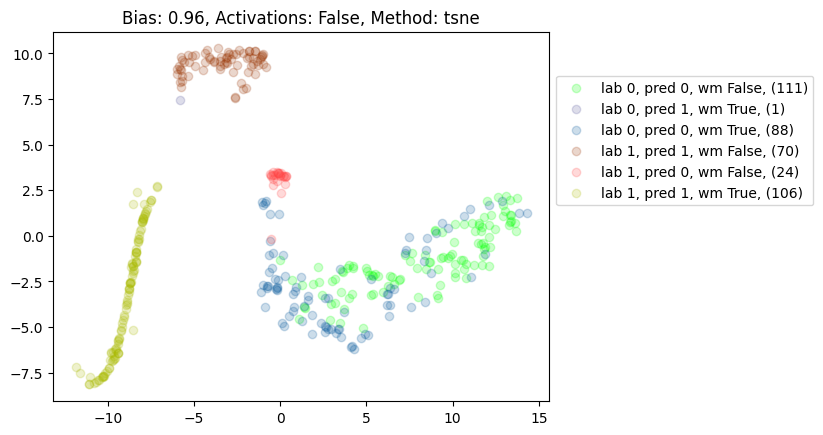

In [149]:
METHOD = 0
res = methods[METHOD].fit_transform(vector.numpy())
ALPHA = 0.2

def ft(color, lab, wm, pred=None):
    d = np.logical_and(watermarks == wm, labels == lab)
    if pred is not None:
        d = np.logical_and(d, predictions == pred)
    if res[d,0].shape[0] > 0:
        print(f"lab {lab}, pred {pred}, wm {wm == 1}, ({res[d,0].shape[0]}), MEAN: {np.mean(res[d], 0)}")
        plt.scatter(
            res[d, 0],
            res[d, 1],
            c=color,
            alpha=ALPHA,
            label=f"lab {lab}, pred {pred}, wm {wm == 1}, ({res[d,0].shape[0]})",
        )


ft("#550", 0, 0, 1)
ft("#0f0", 0, 0, 0)
ft("#559", 0, 1, 1)
ft("#059", 0, 1, 0)

ft("#930", 1, 0, 1)
ft("#f44", 1, 0, 0)
ft("#ab0", 1, 1, 1)
ft("#f0f", 1, 1, 0)

plt.legend(bbox_to_anchor=(1, 0.9))
plt.title(f"Bias: {BIAS}, Activations: {ACTIVATIONS}, Method: {m_names[METHOD]}")

In [109]:
crp_attribution.compute_feature_vis()

computing feature vis
Running Analysis...


  0%|          | 0/3840 [00:00<?, ?it/s]

100%|██████████| 3840/3840 [09:58<00:00,  6.42it/s]


100%|██████████| 36/36 [00:00<00:00, 1721.68it/s]


Layer: convolutional_layers.0


100%|██████████| 4/4 [00:00<00:00, 23.85it/s]


Layer: convolutional_layers.3


  0%|          | 0/4 [00:00<?, ?it/s]/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/zennit/image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)
100%|██████████| 4/4 [00:00<00:00, 17.85it/s]


Layer: linear_layers.0


100%|██████████| 6/6 [00:00<00:00, 17.82it/s]


Layer: linear_layers.2


100%|██████████| 2/2 [00:00<00:00, 17.34it/s]


{'r_max': ['crp-data/nmf_96_5_fv/RelMax_sum_normed/linear_layers.2_',
  'crp-data/nmf_96_5_fv/RelMax_sum_normed/linear_layers.0_',
  'crp-data/nmf_96_5_fv/RelMax_sum_normed/convolutional_layers.3_',
  'crp-data/nmf_96_5_fv/RelMax_sum_normed/convolutional_layers.0_'],
 'a_max': ['crp-data/nmf_96_5_fv/ActMax_sum_normed/convolutional_layers.0_',
  'crp-data/nmf_96_5_fv/ActMax_sum_normed/convolutional_layers.3_',
  'crp-data/nmf_96_5_fv/ActMax_sum_normed/linear_layers.0_',
  'crp-data/nmf_96_5_fv/ActMax_sum_normed/linear_layers.2_'],
 'r_stats': ['crp-data/nmf_96_5_fv/RelStats_sum_normed/linear_layers.2/0_',
  'crp-data/nmf_96_5_fv/RelStats_sum_normed/linear_layers.0/0_',
  'crp-data/nmf_96_5_fv/RelStats_sum_normed/convolutional_layers.3/0_',
  'crp-data/nmf_96_5_fv/RelStats_sum_normed/convolutional_layers.0/0_',
  'crp-data/nmf_96_5_fv/RelStats_sum_normed/linear_layers.2/1_',
  'crp-data/nmf_96_5_fv/RelStats_sum_normed/linear_layers.0/1_',
  'crp-data/nmf_96_5_fv/RelStats_sum_normed/convo

/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


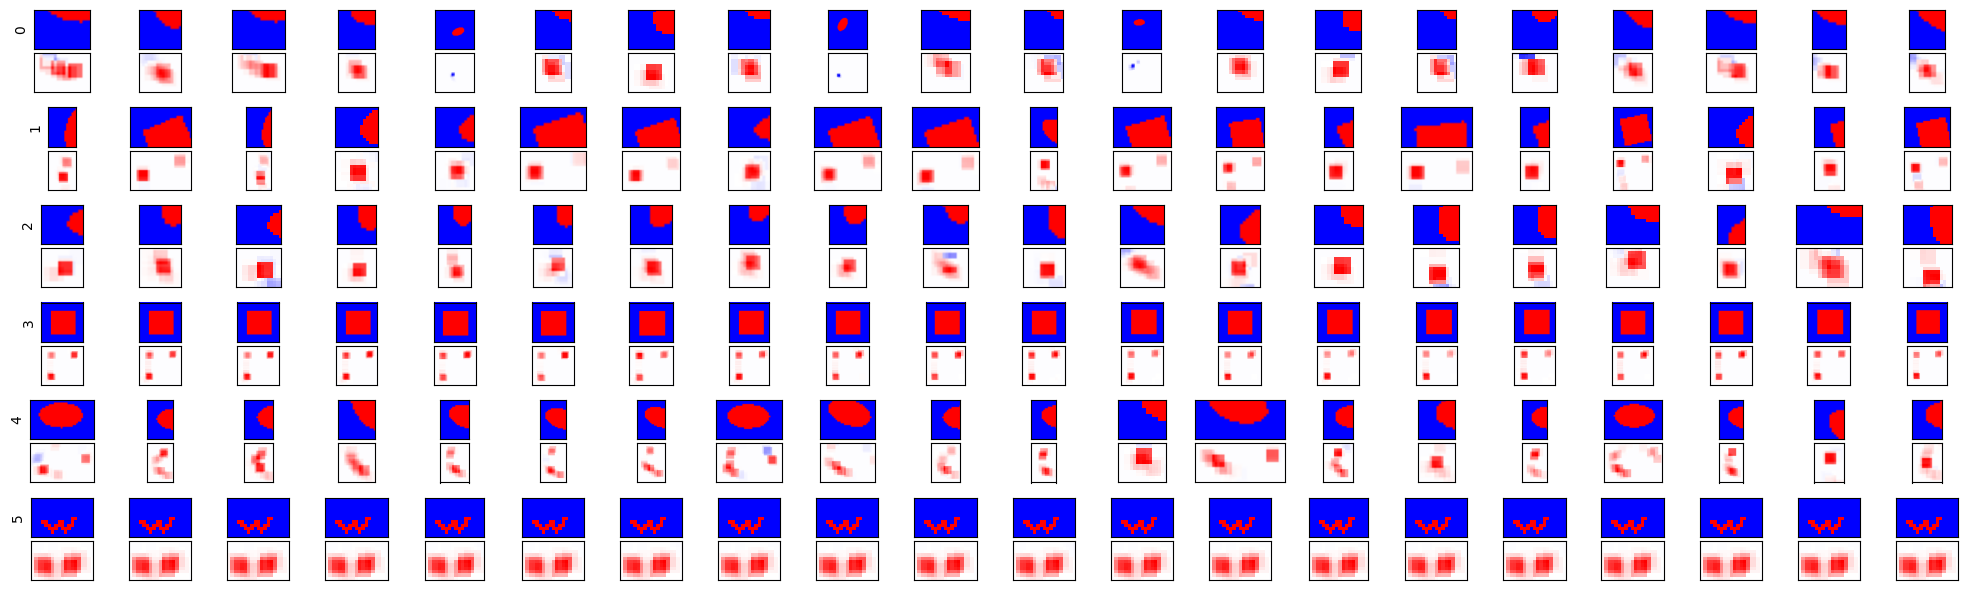

In [138]:
cond_layer = "linear_layers.0"
no_ref_samples = 20
n_neurons = 6

ref_c = crp_attribution.fv.get_max_reference(
    list(range(n_neurons)),
    cond_layer,
    "relevance",
    (0, no_ref_samples),
    composite=crp_attribution.composite,
    rf=True,
)

plot_grid(ref_c, figsize=(no_ref_samples, 6), padding=False)

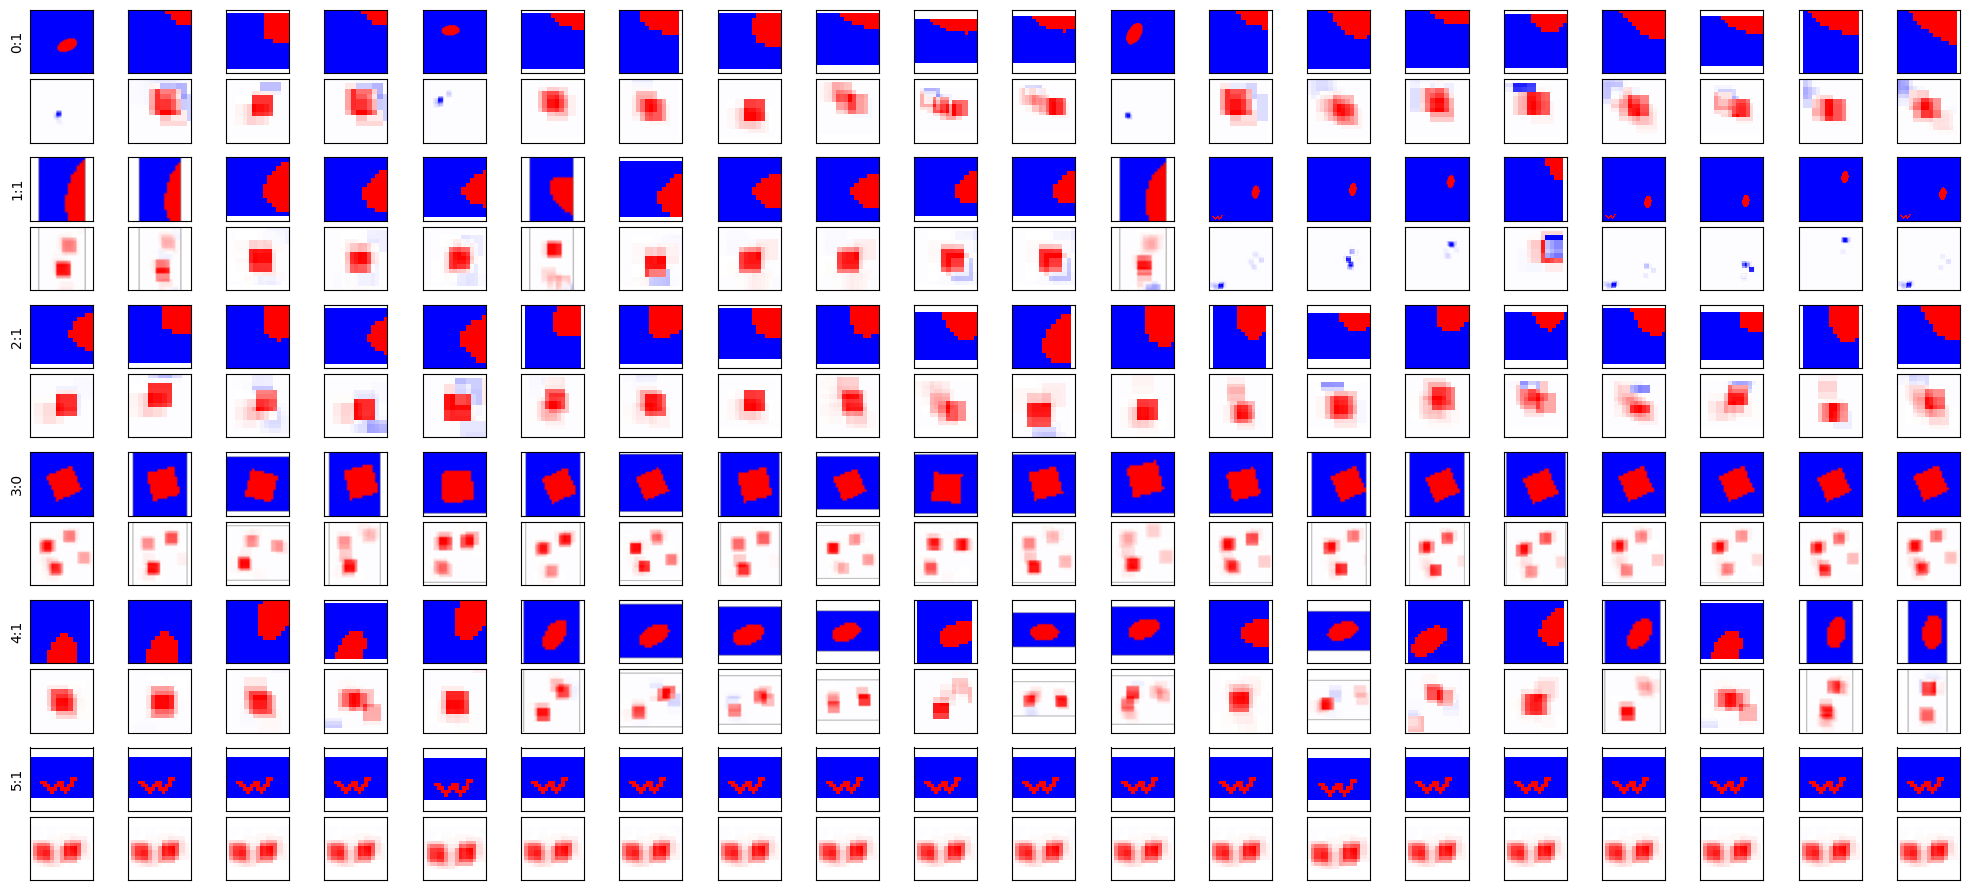

In [111]:
all_refs = {}
for i in range(n_neurons):
    targets, rel = crp_attribution.fv.compute_stats(
        i, cond_layer, "relevance", top_N=1, norm=True
    )
    ref_c = crp_attribution.fv.get_stats_reference(
        i,
        cond_layer,
        [targets],
        "relevance",
        (0, no_ref_samples),
        composite=crp_attribution.composite,
        rf=True,
    )
    all_refs[f"{i}:{targets}"] = ref_c[f"{i}:{targets}"]
plot_grid(
    all_refs,
    figsize=(no_ref_samples, n_neurons* 1.5),
    padding=True,
    symmetric=True,
)

In [112]:
path = f"crp-data/nmf-_{str(BIAS).replace('0.', '')}_5_fv/RelMax_sum_normed/"

data_p = f'{path}linear_layers.0_data.npy'
print(data_p)
data_data = np.load(data_p, mmap_mode="r")
data_data.shape

crp-data/nmf-_96_5_fv/RelMax_sum_normed/linear_layers.0_data.npy


FileNotFoundError: [Errno 2] No such file or directory: 'crp-data/nmf-_96_5_fv/RelMax_sum_normed/linear_layers.0_data.npy'

In [113]:
# MAX RELEVANCE COLLECTING LATENTS

res = torch.zeros((6,40, 6))

for neuron in range(6):
    for ref_sample in range(40):
        index = data_data[ref_sample, neuron]
        latents, watermark = unbiased_ds.get_item_info(index)
        info = [int(watermark), *latents]
        res[neuron, ref_sample] = torch.Tensor(info)
res

tensor([[[ 1.,  1.,  0., 19.,  8.,  0.],
         [ 1.,  1.,  0., 17.,  8.,  0.],
         [ 1.,  1.,  0., 37.,  8.,  0.],
         ...,
         [ 1.,  1.,  1., 18.,  6.,  1.],
         [ 1.,  1.,  0., 23., 31., 14.],
         [ 1.,  1.,  0., 32.,  7.,  1.]],

        [[ 0.,  1.,  5., 39., 30., 30.],
         [ 0.,  1.,  5., 39., 30., 29.],
         [ 0.,  1.,  5., 39., 30., 28.],
         ...,
         [ 1.,  1.,  5., 39., 31., 25.],
         [ 0.,  1.,  5., 39., 30.,  2.],
         [ 0.,  1.,  5., 39., 30.,  1.]],

        [[ 1.,  1.,  4., 32., 31., 28.],
         [ 1.,  1.,  4., 32., 31., 27.],
         [ 1.,  1.,  1., 20.,  0., 31.],
         ...,
         [ 1.,  1.,  5., 26., 31., 30.],
         [ 1.,  1.,  4., 31., 31., 30.],
         [ 1.,  1.,  0., 26., 30., 31.]],

        [[ 0.,  0.,  5., 39., 30., 19.],
         [ 0.,  0.,  5., 39., 30., 15.],
         [ 0.,  0.,  5., 39., 30., 14.],
         ...,
         [ 0.,  0.,  5., 39., 31.,  2.],
         [ 0.,  0.,  5., 39., 31., 1

In [136]:
# WATERMARK IMPORTANCE

watermark_neurons = torch.zeros((6, 40))

for neuron in range(6):
    for ref_sample in range(40):
        index = data_data[ref_sample, neuron]
        latents, watermark = unbiased_ds.get_item_info(index)
        wm, rest, h, p, l = crp_attribution.watermark_neuron_importance(
            index, cond_layer, neuron
        )
        """ if wm > rest and rest <= 0:
            watermark_neurons[neuron, ref_sample] = 1
        elif wm > rest and rest > 0:
            watermark_neurons[neuron, ref_sample] = 2
        elif rest > wm and wm > 0:
            watermark_neurons[neuron, ref_sample] = 3
        elif rest > wm and wm <= 0:
            watermark_neurons[neuron, ref_sample] = 0
        else:
            watermark_neurons[neuron, ref_sample] = 5 """
        if watermark:
            watermark_neurons[neuron, ref_sample] = wm
        else:
            watermark_neurons[neuron, ref_sample] = rest


In [137]:
torch.var(watermark_neurons, dim=1), torch.mean(watermark_neurons, dim=1), watermark_neurons

(tensor([3.9317e-14, 0.0000e+00, 3.9610e-03, 6.7495e+00, 2.4312e-02, 9.7288e-05]),
 tensor([ 2.5173,  0.0000,  2.7315, 19.1020,  0.0497,  2.1725]),
 tensor([[ 2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,
           2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,
           2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,
           2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,
           2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173,  2.5173],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 2.7063,  2.7063,  2

In [162]:
# STATS RELEVANCE COLLECTING LATENTS

path = f"crp-data/nmf_{str(BIAS).replace('0.', '')}_5_fv/RelStats_sum_normed/"

data_0 = np.load(f'{path}linear_layers.0/0_data.npy', mmap_mode="r")
data_1 = np.load(f'{path}linear_layers.0/1_data.npy', mmap_mode="r")
rel_0 = np.load(f'{path}linear_layers.0/0_rel.npy', mmap_mode="r")
rel_1 = np.load(f'{path}linear_layers.0/1_rel.npy', mmap_mode="r")

indices = []
res = torch.zeros((6,40, 7))

for neuron in range(6):
    for ref_sample in range(40):
        index0 = data_0[ref_sample, neuron]
        #wm0, rest, h, p, l = crp_attribution.watermark_importance(index0)
        relevance0 = rel_0[ref_sample, neuron]
        latents0, watermark0 = unbiased_ds.get_item_info(index0)
        latents0 = latents0 / gm.latents_sizes[1:] 
        info0 = torch.Tensor([int(watermark0)* 0.5, *latents0, relevance0])

        index1 = data_1[ref_sample, neuron]
        #wm1, rest, h, p, l = crp_attribution.watermark_importance(index1)
        relevance1 = rel_1[ref_sample, neuron]
        latents1, watermark1 = unbiased_ds.get_item_info(index1)
        latents1 = latents1 / torch.Tensor([2,6,40,32,32])
        info1 = torch.Tensor([int(watermark1)* 0.5, *latents1, relevance1])
        if relevance0 > relevance1:
            res[neuron, ref_sample] = info0
            indices.append(index0)
        else:
            res[neuron, ref_sample] = info1
            indices.append(index1)
        """ else:
            res[neuron, ref_sample] = torch.Tensor([2, 100,100,100,100,100,100, 0]) """

res

tensor([[[0.0000, 0.5000, 0.5000,  ..., 0.6250, 0.5938, 1.0000],
         [0.0000, 0.5000, 0.6667,  ..., 0.0625, 0.8750, 1.0000],
         [0.0000, 0.5000, 0.5000,  ..., 0.3750, 0.9688, 1.0000],
         ...,
         [0.0000, 0.5000, 0.8333,  ..., 0.0938, 0.8438, 0.6490],
         [0.0000, 0.5000, 0.6667,  ..., 0.0000, 0.9375, 0.6475],
         [0.0000, 0.5000, 0.6667,  ..., 0.0000, 0.9062, 0.6468]],

        [[0.0000, 0.5000, 0.8333,  ..., 0.0312, 0.0312, 1.0000],
         [0.0000, 0.5000, 0.8333,  ..., 0.0312, 0.0000, 0.0196],
         [0.0000, 0.5000, 0.6667,  ..., 0.1562, 0.0625, 0.0145],
         ...,
         [0.5000, 0.0000, 0.6667,  ..., 0.0312, 0.0312, 0.0032],
         [0.5000, 0.0000, 0.8333,  ..., 0.0938, 0.0000, 0.0032],
         [0.0000, 0.0000, 0.8333,  ..., 0.0312, 0.0625, 0.0032]],

        [[0.0000, 0.5000, 0.3333,  ..., 0.1562, 0.2188, 1.0000],
         [0.0000, 0.5000, 0.5000,  ..., 0.0000, 0.2188, 1.0000],
         [0.0000, 0.5000, 0.3333,  ..., 0.1875, 0.9688, 1.

In [182]:
variance = torch.var(res,dim=1)
relevant = torch.mean(res, dim=1)
covariance = [torch.cov(res[i,:,:].T) for i in range(6)]
print(variance)

tensor([[0.0000e+00, 0.0000e+00, 1.9213e-02, 7.8628e-02, 1.7375e-02, 2.8736e-02,
         2.2372e-02],
        [4.1026e-02, 3.2692e-02, 2.1207e-02, 8.8051e-02, 1.2113e-03, 1.3296e-03,
         2.4751e-02],
        [0.0000e+00, 0.0000e+00, 3.5595e-02, 6.3660e-02, 6.7383e-03, 1.1853e-01,
         0.0000e+00],
        [6.0096e-02, 0.0000e+00, 0.0000e+00, 7.8165e-04, 5.8193e-02, 6.2087e-02,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2115e-03, 9.3978e-02, 4.7876e-02,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.3875e-02, 9.1134e-02, 2.7141e-02, 8.8836e-03,
         1.5086e-05]])


In [183]:
for i in covariance:
    for j in i:
        print(", ".join(list([str(round(float(x), 3)) for x in j])))
    print("_______")

0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
0.0, 0.0, 0.019, -0.006, -0.005, 0.006, -0.005
0.0, 0.0, -0.006, 0.079, 0.001, -0.004, 0.003
0.0, 0.0, -0.005, 0.001, 0.017, -0.011, 0.002
0.0, 0.0, 0.006, -0.004, -0.011, 0.029, -0.006
0.0, 0.0, -0.005, 0.003, 0.002, -0.006, 0.022
_______
0.041, -0.008, 0.006, 0.007, 0.001, -0.002, -0.003
-0.008, 0.033, -0.012, -0.011, 0.002, 0.003, 0.011
0.006, -0.012, 0.021, 0.009, 0.001, -0.002, 0.002
0.007, -0.011, 0.009, 0.088, -0.001, -0.002, -0.005
0.001, 0.002, 0.001, -0.001, 0.001, 0.0, -0.0
-0.002, 0.003, -0.002, -0.002, 0.0, 0.001, 0.0
-0.003, 0.011, 0.002, -0.005, -0.0, 0.0, 0.025
_______
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
0.0, 0.0, 0.036, 0.006, 0.002, -0.003, 0.0
0.0, 0.0, 0.006, 0.064, 0.006, 0.024, 0.0
0.0, 0.0, 0.002, 0.006, 0.007, 0.01, 0.0
0.0, 0.0, -0.003, 0.024, 0.01, 0.119, 0.0
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
_______
0.06, 0.0, 0.0, 0.0, -0.013, -0.016, 0.0
0.0, 0.0, 0.0, 0.0, 0

/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


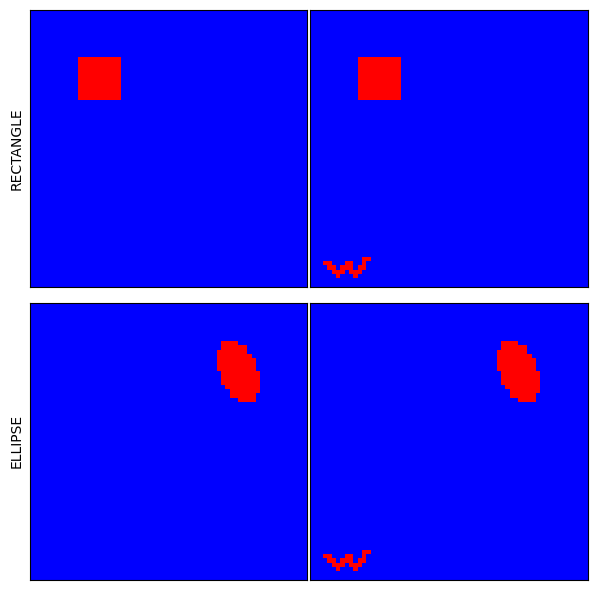

In [165]:
r0 = gm.load_image(0, False)
r1 = gm.load_image(0, True)
e0 = gm.load_image(300000, False)
e1 = gm.load_image(300000, True)
imgs = {
    "RECTANGLE": [
        r0[0],
        r1[0],
    ],
    "ELLIPSE": [e0[0], e1[0]],
}

plot_grid(imgs)

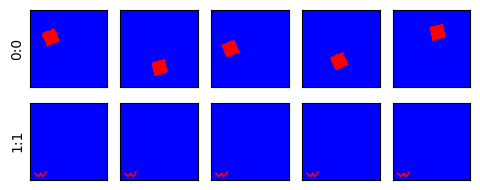

In [42]:
crp_attribution.make_all_relevances("linear_layers.2", range(2))

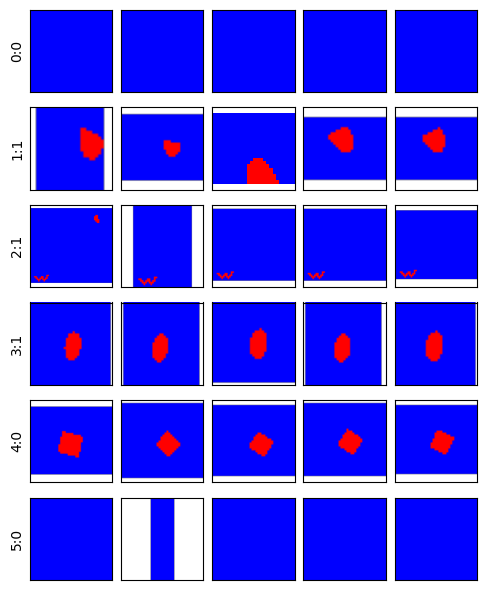

In [168]:
crp_attribution.make_all_relevances("linear_layers.0", range(6))

output: tensor([[ 1.5066, 10.0607]]), 
 latents: [ 1  1 32 16  0], 
 watermark: True, 
 prediction:1  
 
 convolutional_layers.0: 
 2: 42.26%, 3: 31.2%, 1: 16.43%, 0: -10.11% 
 
 convolutional_layers.3: 
 1: 48.02%, 2: 30.63%, 3: 21.35%, 0: 0.0% 
 
 linear_layers.0: 
 2: 100.0%, 3: 0.0%, 5: 0.0%, 4: 0.0%, 0: 0.0%, 1: 0.0% 
 
 linear_layers.2: 
 1: 100.0%, 0: 0.0% 
tensor(-0.0044) tensor(0.0122)


/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/zennit/image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)


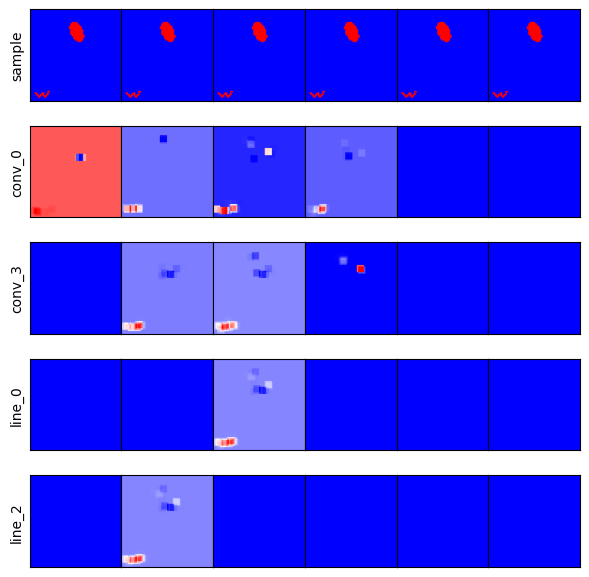

In [166]:
res = crp_attribution.image_info(320000, verbose=True)
# 320000, 50, 0, 320300

In [116]:
activationvector = activationvector / torch.abs(activationvector).max()
vector = (vector) / torch.abs(vector).max()

In [97]:
with open("model_accuracies2.json", "r") as f:
    analysis_data = json.load(f)
    
data = sorted(analysis_data.values(), key=lambda x: x["bias"])
experiments = [a["nmf_experiment"] for a in data]
experimentstsne = [a["tsne_experiment"] for a in data]
relevance_distance = [a["relevance_distance"] for a in data]
biases = [a["bias"] for a in  data]



[[[[nan, nan, nan, nan, nan, nan], 'label0_wm0'], [[nan, nan, nan, nan, nan, nan], 'label0_wm1'], [[nan, nan, nan, nan, nan, nan], 'label1_wm0'], [[nan, nan, nan, nan, nan, nan], 'label1_wm1']], [[[0.0037343595176935196, -3.412113437661901e-05, 0.0010301070287823677, 0.49008801579475403, 0.016111113131046295, 0.006526961922645569], 'label0_wm0'], [[0.0017440934898331761, 0.0, 0.0014021295355632901, 0.47795525193214417, 0.004941856022924185, 0.01726209931075573], 'label0_wm1'], [[0.060205020010471344, -0.00010132329043699428, 0.0003867250052280724, -0.0042736465111374855, 0.0002964150917250663, 0.20330166816711426], 'label1_wm0'], [[0.04648815840482712, 0.0, 0.0, -0.002795765409246087, 0.00010151911556022242, 0.2835982143878937], 'label1_wm1']], [[[nan, nan, nan, nan, nan, nan], 'label0_wm0'], [[nan, nan, nan, nan, nan, nan], 'label0_wm1'], [[nan, nan, nan, nan, nan, nan], 'label1_wm0'], [[nan, nan, nan, nan, nan, nan], 'label1_wm1']], [[[0.0, 0.0003728833398781717, 0.00466820877045393,

Text(0.5, 1.0, 'Mean Euclidean Distance of Latent Vector Samples From Groups')

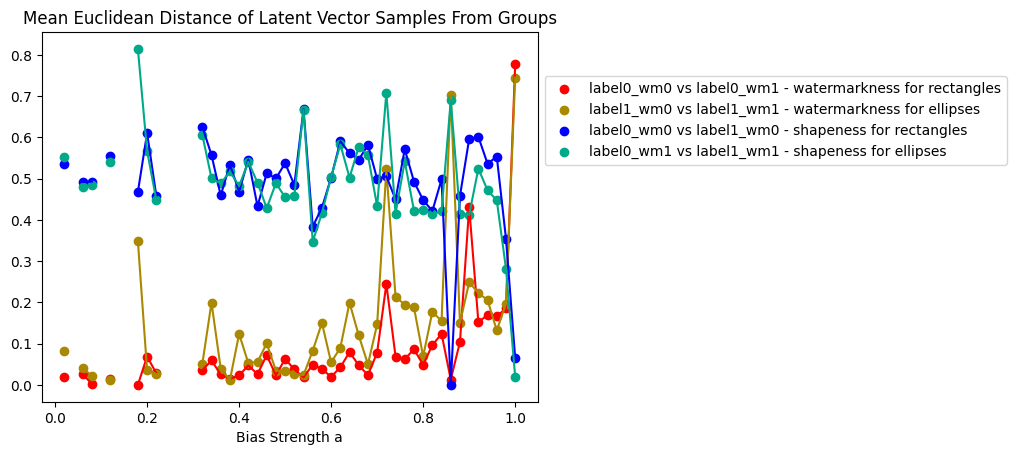

In [110]:
# relevance_distance
print(relevance_distance)
means = [[np.array(a[i][0]) for i in range(4)] for a in relevance_distance]
labels = [relevance_distance[10][i][1] for i in range(4)]
print(len(means))

diff0 = [np.linalg.norm((m[0]) - (m[1])) for m in means]
diff1 = [np.linalg.norm((m[2]) - (m[3])) for m in means]
diff2 = [np.linalg.norm((m[0]) - (m[2])) for m in means]
diff3 = [np.linalg.norm((m[1]) - (m[3])) for m in means]

plt.scatter(
    biases,
    diff0,
    label=f"{labels[0]} vs {labels[1]} - watermarkness for rectangles",
    color="#f00",
)
plt.scatter(
    biases,
    diff1,
    label=f"{labels[2]} vs {labels[3]} - watermarkness for ellipses",
    color="#a80",
)
plt.scatter(
    biases,
    diff2,
    label=f"{labels[0]} vs {labels[2]} - shapeness for rectangles",
    color="#00f",
)
plt.scatter(
    biases,
    diff3,
    label=f"{labels[1]} vs {labels[3]} - shapeness for ellipses",
    color="#0a8",
)

plt.plot(biases, diff0, color="#f00")
plt.plot(biases, diff1, color="#a80")
plt.plot(biases, diff2, color="#00f")
plt.plot(biases, diff3, color="#0a8")
plt.legend(bbox_to_anchor=(1, 0.9))

plt.xlabel("Bias Strength a")
plt.title("Mean Euclidean Distance of Latent Vector Samples From Groups")

In [25]:
L1  https://transformer-circuits.pub/2023/monosemantic-features

TCAV -> 

multipliziere activations in latent space mit basisvektoren 
https://arxiv.org/abs/2303.12641

[['NaN', 'NaN'],
 [-1.016903042793274, -0.2855379581451416],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 [-2.840420722961426, -5.249847888946533],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 [0.3464526832103729, 0.4420403838157654],
 [-1.7405600547790527, 2.150456666946411],
 ['NaN', 'NaN'],
 [-0.12719225883483887, 1.401840090751648],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 [1.2634450197219849, 5.118646144866943],
 ['NaN', 'NaN'],
 [0.3412220776081085, -2.3169546127319336],
 ['NaN', 'NaN'],
 ['NaN', 'NaN'],
 [-0.818174421787262, 1.8147830963134766]]

51


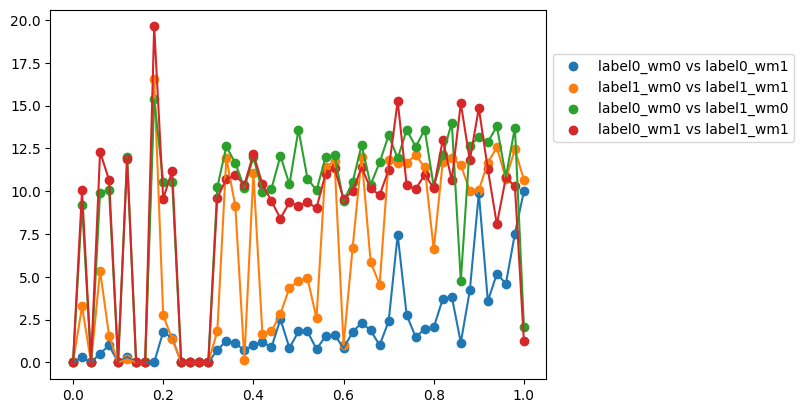

In [93]:
#experimentstsne

means = [[np.array(a[i][0]) if i < len(a) else np.array([0,0])  for i in range(4)] for a in experimentstsne]
labels = [experimentstsne[30][i][1].replace("_pred0", "") for i in range(4)]
print(len(means))

diff0 = [np.linalg.norm((m[0]) - (m[1])) for m in means]
diff1 = [np.linalg.norm((m[2]) - (m[3])) for m in means]
diff2 = [np.linalg.norm((m[0]) - (m[2])) for m in means]
diff3 = [np.linalg.norm((m[1]) - (m[3])) for m in means]

plt.scatter(biases, diff0, label=f"{labels[0]} vs {labels[1]}")
plt.scatter(biases, diff1, label=f"{labels[2]} vs {labels[3]}")
plt.scatter(biases, diff2, label=f"{labels[0]} vs {labels[2]}")
plt.scatter(biases, diff3, label=f"{labels[1]} vs {labels[3]}")

plt.plot(biases, diff0, )
plt.plot(biases, diff1, )
plt.plot(biases, diff2, )
plt.plot(biases, diff3,)
plt.legend(bbox_to_anchor=(1, 0.9))

plt.ylabel("distance between means of groups")
plt.xlabel("Bias Strength a")
plt.title("")

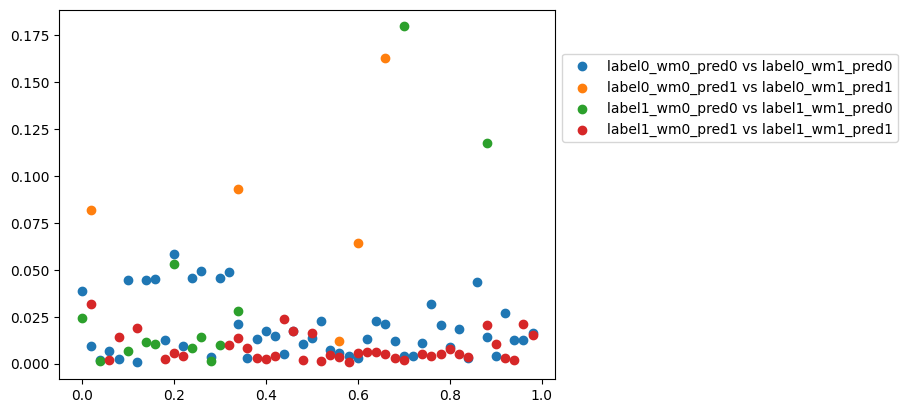

In [80]:
#experiments
method = "relevance_pca"

d = [[np.array(a[method][i][0]) for a in experiments] for i in range(8)]
means = [
    [
        np.array(a[method][i][0])
        #if np.isfinite(a[method][i][0][0])
        #else np.array([0, 0])
        for i in range(8)
    ]
    for a in experiments
]
diff0 = [np.linalg.norm((m[0]) - (m[2])) for m in means]
diff1 = [np.linalg.norm((m[1]) - (m[3])) for m in means]
diff2 = [np.linalg.norm((m[4]) - (m[6])) for m in means]
diff3 = [np.linalg.norm((m[5]) - (m[7])) for m in means]

#diff0 = [np.linalg.norm((m[0]) - (m[3])) for m in means]
#diff1 = [np.linalg.norm((m[4]) - (m[7])) for m in means]

plt.scatter(biases, diff0, label="label0_wm0_pred0 vs label0_wm1_pred0")
plt.scatter(biases, diff1, label="label0_wm0_pred1 vs label0_wm1_pred1")
plt.scatter(biases, diff2, label="label1_wm0_pred0 vs label1_wm1_pred0")
plt.scatter(biases, diff3, label="label1_wm0_pred1 vs label1_wm1_pred1")
plt.legend(bbox_to_anchor=(1, 0.9))

label0_wm0_pred0
label0_wm0_pred1
label0_wm1_pred0
label0_wm1_pred1
label1_wm0_pred0
label1_wm0_pred1
label1_wm1_pred0
label1_wm1_pred1


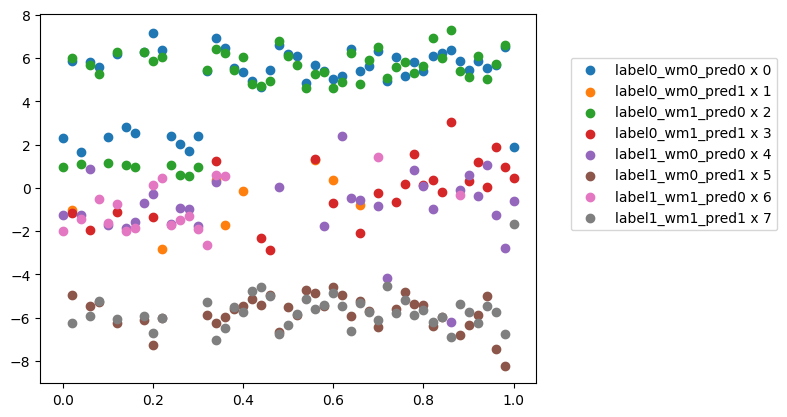

In [68]:
labels = [experiments[0][method][i][1] for i in range(8)]
for i in range(8):
    un_nan = [x if x[0] != "NaN" else [np.nan, np.nan] for x in d[i]]
    x_i = [x[0] for x in un_nan]
    y_i = [x[1] for x in un_nan]
    plt.scatter(biases,x_i, label=f'{labels[i]} x {i}')
    print(labels[i])
    #plt.scatter(biases,y_i, label=f'{labels[i]} y')
plt.legend(bbox_to_anchor=(1.5, 0.9))


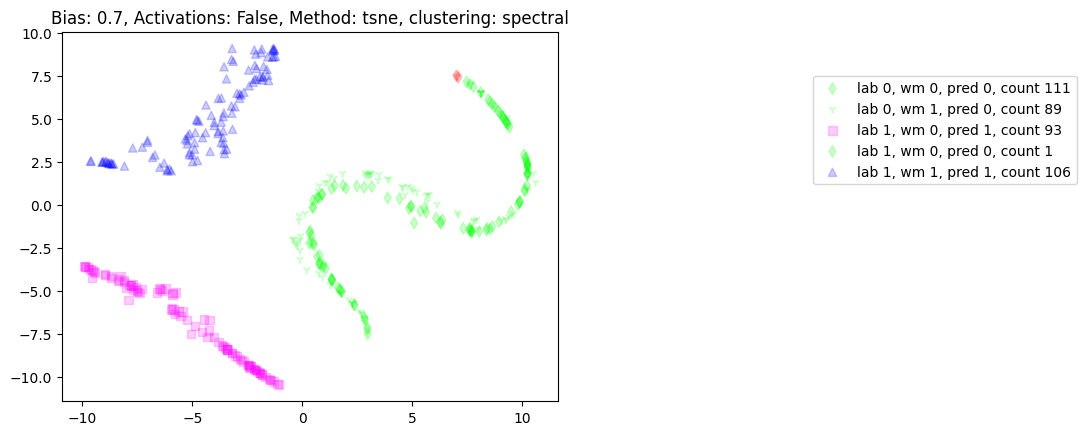

In [81]:
spectral = SpectralClustering(n_clusters=4).fit(vector.numpy())
kmeans = KMeans(n_clusters=4).fit(vector.numpy())
clusterings = [spectral, kmeans]
cname = ["spectral", "kmeans"]
C = 0
ALPHA = 0.2
symbols = {
    "#550": "P",
    "#0f0": "d",
    "#559": "o",
    "#059": "1",
    "#a50": "s",
    "#f00": "d",
    "#aa0": "^",
    "#f0f": "s",
}

cols = ["#0f0", "#f00", "#00f", "#f0f"]

def ft(color, lab, wm, pred=None):
    d = np.logical_and(watermarks == wm, labels == lab)
    if pred is not None:
        d = np.logical_and(d, predictions == pred)
    sorted_nmf_res = res[d]  # np.sort(nmf_res[d, :], axis=1) #
    colors = [cols[i] for i in clusterings[C].labels_[d]]
    if len(colors) > 0:
        plt.scatter(
            sorted_nmf_res[:, 0],
            sorted_nmf_res[:, 1],
            c=colors,
            marker=symbols[color],
            alpha=ALPHA,
            label=f"lab {lab}, wm {wm}, pred {pred}, count {res[d,0].shape[0]}",
        )


plt.title(f"Bias: {BIAS}, Activations: {ACTIVATIONS}, Method: {m_names[METHOD]}, clustering: {cname[C]}")
ft("#550", 0, 0, 1)
ft("#0f0", 0, 0, 0)
ft("#559", 0, 1, 1)
ft("#059", 0, 1, 0)
ft("#a50", 1, 0, 1)
ft("#f00", 1, 0, 0)
ft("#aa0", 1, 1, 1)
ft("#f0f", 1, 1, 0)
plt.legend(bbox_to_anchor=(1.5, 0.9))